# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

---

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import json
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from time import time

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio

#### Basic Infos:

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print(f'The shape of portfolio data is {portfolio.shape}')
print(f'Null values statistics is: \n{portfolio.isnull().sum()}')
print(f'There are {portfolio.id.nunique()} unique ids.')


The shape of portfolio data is (10, 6)
Null values statistics is: 
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64
There are 10 unique ids.


In [5]:
print(f"There are the following offer types: \n "
      f"{portfolio.groupby('offer_type').id.count()}")

There are the following offer types: 
 offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64


### 2. Profiles

#### Basic Infos:

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**NOTE:** from the `head` we can already see that there are missing values in `income` and `gender`, and `118` seems to represent missing ages.

In [7]:
print(f'The shape of Profile data is {profile.shape}')
print(f'Null values statistics is: \n{profile.isnull().sum()}')
print(f'There are {profile.id.nunique()} unique ids.')

The shape of Profile data is (17000, 5)
Null values statistics is: 
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
There are 17000 unique ids.


In [8]:
profile_no_age = profile[profile.age==118]

In [9]:
print(f'{profile_no_age.count()}')
profile_no_age.head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


From above we can see that rows without `age` also miss `income` and `gender`, hence, these rows will be dropped in later operations. 

#### Distributions:

In [10]:
print(f"The gender distribution is {profile.groupby('gender').id.count()}")

The gender distribution is gender
F    6129
M    8484
O     212
Name: id, dtype: int64


The Age Histogram


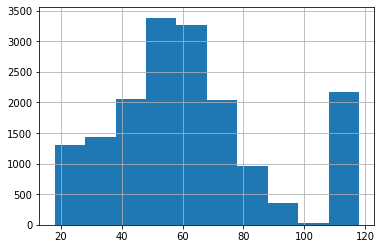

In [11]:
print('The Age Histogram')
profile.age.hist()

The Income Histogram


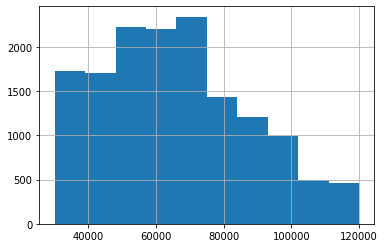

In [12]:
print('The Income Histogram')
profile.income.hist()

### 3. Transcript

#### Basic Infos:

In [13]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [14]:
print(f'The shape of Transcript data is {transcript.shape}')
print(f'Null values statistics is: \n{transcript.isnull().sum()}')
print(f'There are {transcript.person.nunique()} unique ids.')

The shape of Transcript data is (306534, 4)
Null values statistics is: 
person    0
event     0
value     0
time      0
dtype: int64
There are 17000 unique ids.


#### Distributions

In [15]:
print(f"Event Distribution:\n{transcript.groupby('event').person.count()}")

Event Distribution:
event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64


We need to extract information from the `value` column for further exploration.

In [16]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], 
                       axis=1)

transcript['clean_id'] = np.where(transcript['offer id'].isnull() & 
                                  transcript['offer_id'].notnull(), 
                                  transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [17]:
print(f'There are {transcript.offer_id.nunique()} unique offers')

There are 10 unique offers


---

## Preprocessing

### 1. Merge `portfolio` and `transcript`

To find out the connection between transaction and offer, we need to combine the information in `portfolio` and `transcript`, and then create subsets of different offer-event combination for later feature engineering and modeling.

In [18]:
transcript = transcript.merge(portfolio,
                              how='left',
                              left_on='offer_id',
                              right_on='id')

print(f"This is the Event Distribution:\n"
      f"{transcript.groupby(['event', 'offer_type'])['offer_type'].count()}")


event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

### 2. Subset by Categories

Typically, we have the following customer behaviours:

    1. make the transaction after receiving and viewing the offer

    2. viewing the offer and make no transaction

    3. make the transaction without receiving or viewing the offer

As for offer types, we can see from above that `offer_id` is not directly linked to `transaction` events, hence, we need to establish these links.

For `bogo` and `discount` offer, they have an obvious consequence of offer received, viewed, transaction and hence the offer completes.

However, for the `information` offer, there's no reward step for the easy links to transactions, we need a work around.

#### 2.1 `bogo` and `discount`

##### 2.1.1 Responsive Customers

Only the first kind of customers are regarded as responsive.

Before flagging any data, we need to reorganize the data first.

In [ ]:
# drop the dummy columns created by `merge`
transcript_processed = pd.DataFrame(transcript)

transcript_processed = transcript_processed.drop(columns=['reward_x',
                                                          'reward_y'],
                                                 axis=1,inplace=False)

# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head(10)

In [21]:
offer_completed = transcript_processed[['time','offer_id','person','event']] \
                                      [(transcript_processed['event']== \
                                            'transaction') |
                                       (transcript_processed['event']==
                                            'offer viewed')]

offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [22]:
# create the complete whole dataset for filtered data
transcript_processed = transcript_processed.merge(offer_completed,
                                                  how='left',
                                                  on=['person','time','event'])

# drop the dummy columns created by `merge`
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'] \
                                                .isnull(),
                                            transcript_processed['offer_id_y'],
                                            transcript_processed['offer_id_x'])

transcript_processed.drop(columns=['offer_id_x','offer_id_y'],
                          axis=1, inplace=True)

,person,event,value,time,amount,offer_id_x,channels,difficulty,duration,offer_type,id,offer_id_y
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [24]:
transcript_processed.head()

,person,event,value,time,amount,channels,difficulty,duration,offer_type,id,offer_id
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed


In [25]:
transcript_processed = transcript_processed.merge(portfolio,
                                                  how = 'left',
                                                  left_on='offer_id',
                                                  right_on='id')

transcript_processed['duration'] = np.where(transcript_processed['duration_x'] \
                                                .isnull(),
                                            transcript_processed['duration_y'],
                                            transcript_processed['duration_x'])

# drop the dummy columns created by `merge`
transcript_processed.drop(columns=['duration_x','offer_type_x',
                                   'difficulty_x','channels_x','duration_y'],
                         axis=1, inplace=True)

transcript_processed.rename(columns={'channels_y':'channels',
                                     'reward_y':'reward',
                                     'difficulty_y':'difficulty',
                                     'offer_type_y':'offer_type'},
                            inplace=True)

In [26]:
transcript_processed.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0


Now we can extract the transactions which were completed after receiving and viewing, by checking if the `offer_id` is the same before and after the transaction.

In [27]:
# subsets of only viewed, transaction, and offer completed events
transactions_after_viewed = \
    transcript_processed[(transcript_processed['event']=='offer viewed')|
                         (transcript_processed['event']=='transaction')|
                         (transcript_processed['event']=='offer completed')]\
                             .copy()

# add pre-transaction offer_id
transactions_after_viewed['pre_offer_id'] = \
    transactions_after_viewed.groupby(['person', 'offer_id'])\
        ['offer_id'].shift()

# create flag for responded offer
transactions_after_viewed['completed_offer'] = \
    np.where(transactions_after_viewed['pre_offer_id']== \
        transactions_after_viewed['offer_id'], 1, 0)

In [28]:
transactions_after_viewed.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,0
6,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,3f207df678b143eea3cee63160fa8bed,1
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0


In [29]:
# restore the 'offer_received' events
offer_received = transcript_processed[transcript_processed['event']== \
                                      'offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed)\
                           .sort_values(['person','time'])

transcript_processed.head()

/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,0.0


Before going any further, we need to create subsets for different offer types, as we will process them differently due to their different behaviour sequence.

In [30]:
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()

discount = transcript_processed[transcript_processed['offer_type']== \
                                'discount'].copy()

informational = transcript_processed[transcript_processed['offer_type']== \
                                     'informational'].copy()


In [31]:
bogo.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
5,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,0.0
8,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 14.11},528,14.11,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,NaN


In [32]:
discount.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
9,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,fafdcd668e3743c1bb461111dcafc2a4,10.0,NaN,NaN
11,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,fafdcd668e3743c1bb461111dcafc2a4,10.0,NaN,0.0
12,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},540,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,fafdcd668e3743c1bb461111dcafc2a4,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 13.56},552,13.56,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,fafdcd668e3743c1bb461111dcafc2a4,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,NaN,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,discount,2906b810c7d4411798c6938adc9daaa5,7.0,NaN,NaN


In [33]:
informational.head()

,person,event,value,time,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,0.0



For `bogo` and `discount` offer, responded offer can be filtered with `offer_complete` events, and responded informational offers can be filtered with the 'transaction' events.

In [34]:
# extract responded offer under bogo and discount type
bogo_completed = bogo[['person','offer_id']] \
                     [(bogo['completed_offer']==1) &
                      (bogo['event']=='offer completed')] \
                     .groupby(['person','offer_id']) \
                     .count().reset_index()

discount_completed = discount[['person','offer_id']] \
                             [(discount['completed_offer']==1) &
                              (discount['event']=='offer completed')] \
                             .groupby(['person','offer_id'])\
                             .count().reset_index()

Next, we need to filter customers who only viewed the offers, and customers who only received the offer.

In [35]:
bogo_ids_transaction_completed = bogo[['person','offer_id']] \
                                     [(bogo['event']=='transaction') |
                                      (bogo['event']=='offer completed')] \
                                     .groupby(['person','offer_id']) \
                                     .count().reset_index()

bogo_ids_received = bogo[['person','offer_id']] \
                        [bogo['event']=='offer received'] \
                        .groupby(['person','offer_id']) \
                        .count().reset_index()

# offers viewed without transaction and completion
bogo_merged = bogo_ids_transaction_completed.merge(bogo_ids_received,
                                                   how='right',
                                                   on=['person','offer_id'],
                                                   indicator=True)

bogo_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,both
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [36]:
# the same processing on discount offers
discount_ids_transaction_completed = \
    discount[['person','offer_id']][(discount['event']=='transaction') |
                                    (discount['event']=='offer completed')]\
            .groupby(['person','offer_id']).count().reset_index()

discount_ids_received = discount[['person','offer_id']] \
                                [discount['event']=='offer received'] \
                                .groupby(['person','offer_id']) \
                                .count().reset_index()

discount_merged = \
    discount_ids_transaction_completed.merge(discount_ids_received,
                                             how='right',
                                             on=['person','offer_id'],
                                             indicator=True)

discount_merged.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


##### 2.1.2 Less Responsive Customers

Then, we can filter out less responsive customers who viewed the offer without any transaction,  and customers who didn't the received offer.

In [37]:
bogo_no_transaction = bogo_merged[bogo_merged['_merge']=='right_only']
bogo_no_transaction = bogo_no_transaction.merge(transcript_processed,
                                                how='left',
                                                on=['person','offer_id'])

bogo_viewed = bogo_no_transaction[['person','offer_id']] \
                                 [bogo_no_transaction['event']=='offer viewed']\
                                 .groupby(['person','offer_id']) \
                                 .count().reset_index()

bogo_no_transaction.drop(['_merge'], axis=1, inplace=True)

bogo_no_view = bogo_no_transaction.merge(bogo_viewed[['person','offer_id']],
                                         how='left', indicator=True)

bogo_no_view = bogo_no_view[bogo_no_view['_merge']=='left_only'].copy()


In [38]:
# do the same  on discount offers

discount_no_transaction = \
    discount_merged[discount_merged['_merge']=='right_only']
discount_no_transaction = \
    discount_no_transaction.merge(transcript_processed,
                                  how='left',
                                  on=['person','offer_id'])

discount_viewed = \
    discount_no_transaction[['person','offer_id']] \
                           [discount_no_transaction['event']=='offer viewed'] \
                           .groupby(['person','offer_id']) \
                           .count().reset_index()

discount_no_transaction.drop(['_merge'], axis=1, inplace=True)

discount_no_view = \
    discount_no_transaction.merge(discount_viewed[['person','offer_id']],
                                  how='left', indicator=True)

discount_no_view = discount_no_view[discount_no_view['_merge']=='left_only'] \
                                   .copy()


##### 2.1.3 Unrelated Customers

After above processes, there are still some more transcripts that are not related to offers according to given data

In [39]:
bogo_unrelated = bogo[['person','offer_id']] \
                     [(bogo['event']=='offer completed') &
                      (bogo['completed_offer']!=1)] \
                     .groupby(['person','offer_id'])\
                     .count().reset_index()

discount_unrelated = discount[['person','offer_id']] \
                             [(discount['event']=='offer completed') &
                              (discount['completed_offer']!=1)]\
                             .groupby(['person','offer_id'])\
                             .count().reset_index()

##### 2.1.4. Group Subsets for Feature Engineering

As explained previously, `bogo` and `discount` offers both have a complete sequence of actions, hence these two will be grouped for later use.

In [40]:
# combine the two kind of customers cases which are focused on
bogo_completed['offer_responded'] = 1
bogo_viewed['offer_responded'] = 0
bogo_offer = bogo_completed.append(bogo_viewed, sort=False)

discount_completed['offer_responded'] = 1
discount_viewed['offer_responded'] = 0
discount_offer = discount_completed.append(discount_viewed, sort=False)


#### 2.2 `informational`

For `informational` offers, we count transactions within the offer duration as responded, hence we need to process the given time related columns.

In [41]:
#convert time into days
informational['day_offer'] = informational['time']/24

#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)
informational = informational.sort_values(['person','day_offer',
                                           'event','offer_id'])

#get difference in time for informational offers
informational['diff'] = \
    informational[(informational['offer_type']=='informational') &
                  ((informational['event']=='offer received') |
                   (informational['event']=='transaction'))] \
                 .groupby(['person','offer_id'])['day_offer'].diff()

informational['valid_completion']=np.nan

#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],
                  'valid_completion'] = 1
#fill any missing values with 0 flag
informational['valid_completion'] = \
    informational['valid_completion'].fillna(value=0)

In [42]:
informational.head()

,person,event,amount,id_x,offer_id,reward,channels,difficulty,offer_type,id_y,duration,completed_offer,day_offer,diff,valid_completion
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,NaN,7.0,NaN,0.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,0.0,8.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,1.0,9.5,2.5,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,NaN,14.0,NaN,0.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,3f207df678b143eea3cee63160fa8bed,4.0,0.0,15.5,NaN,0.0


In [43]:
#flag responded offers where completed_offer=1 and valid_completion=1
informational['offer_responded'] = \
    np.where(((informational['completed_offer']==1) &
              (informational['valid_completion']==1)), 1, 0)

In [44]:
info_completed = informational[['person','offer_id']] \
                              [informational['offer_responded']==1] \
                              .groupby(['person','offer_id']) \
                              .sum().reset_index()

In [45]:
informational_ids_transaction_completed = \
    informational[['person','offer_id']] \
                 [(informational['event']=='transaction') |
                  (informational['event']=='offer completed')] \
                 .groupby(['person','offer_id']) \
                 .count().reset_index()

informational_ids_received = \
    informational[['person','offer_id']] \
                 [informational['event']=='offer received'] \
                 .groupby(['person','offer_id']) \
                 .count().reset_index()

informational_merged = \
    informational_ids_transaction_completed \
        .merge(informational_ids_received,
               how='right',
               on=['person','offer_id'],
               indicator=True)

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,both
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,both
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,both
3,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,both
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,both


In [ ]:
informational_merged.head()

In [46]:
informational_no_transaction = \
    informational_merged[informational_merged['_merge']=='right_only']

informational_no_transaction = \
    informational_no_transaction.merge(transcript_processed,
                                       how='left',
                                       on=['person','offer_id'])

informational_viewed = \
    informational_no_transaction[['person','offer_id']] \
                                [informational_no_transaction['event']== \
                                     'offer viewed'] \
                                .groupby(['person','offer_id']) \
                                .count().reset_index()

informational_no_transaction.drop(['_merge'], axis=1, inplace=True)

informational_no_view = \
    informational_no_transaction.merge(
            informational_viewed[['person','offer_id']],
            how='left',
            indicator=True)

informational_no_view = \
    informational_no_view[informational_no_view['_merge']=='left_only'].copy()


In [47]:
info_completed['offer_responded']=1
informational_viewed['offer_responded']=0
informational_offer = info_completed.append(informational_viewed, sort=False)

## Feature engineering

After basic processing, the next step will look if there are any columns that can be used to create new features.

- generate a new column for length of customer's membership

In [48]:
profile.rename(columns={'id':'person'},inplace=True)

In [49]:
#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the ength of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile, how='left', on='person')
    
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])

    df = df.drop('became_member_on', axis=1, inplace=False)

    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365) + \
                                                    (30*df['month'])+df['day']

    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

In [50]:
bogo_offer=member_since(bogo_offer)
discount_offer=member_since(discount_offer)
informational_offer=member_since(informational_offer)

In [51]:
bogo_offer.head()

,person,offer_id,offer_responded,gender,age,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,O,40,57000.0,39.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,F,59,90000.0,824.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,F,24,60000.0,771.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,F,24,60000.0,771.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,F,55,74000.0,158.0


- generate the count of offer received for each user

In [52]:
transcript.head()

,person,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [53]:
# generate the count of offers received per person
offer_cnt = transcript_processed[
    transcript_processed['event']=='offer received'] \
    .groupby(['person','offer_id','time']) \
    .count()['event'].reset_index()

offer_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

offer_cnt.drop(['time'], axis=1, inplace=True)

# ensure only unique person-offer_id pairs
offer_cnt=offer_cnt.groupby(['person','offer_id']).sum().reset_index()
offer_cnt.head()

,person,offer_id,offer_received_cnt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


- subtract the transactions which's not related to the offer

In [54]:
# subtract the transactions which's not related to the offer
transactions_not_related = \
    transcript_processed[(transcript_processed['event']=='transaction') &
                         (transcript_processed['completed_offer']==0)] \
                         .groupby(['person','offer_id'])['amount'] \
                         .sum().reset_index()

transactions_not_related.rename(columns={'amount':'amount_invalid'},
                                inplace=True)

- calculate the time lap between offers

In [55]:
# convert time into days
transcript_processed['day_offer'] = transcript_processed['time'] / 24
# drop unnecessary columns
transcript_processed.drop(['time'], axis=1, inplace=True)

# calculate the time between offers
transcript_processed['time_gap'] = \
    transcript_processed[transcript_processed['event']=='offer received'] \
        .groupby(['person','offer_id'])['day_offer'].diff()

# fill missing values with 0
transcript_processed['time_gap'] = transcript_processed['time_gap'] \
                                       .fillna(value=0)

df_time_gap = transcript_processed.groupby(['person','offer_id'])['time_gap'] \
                                  .sum().reset_index()

- Merge the temporary data created above together, then drop the missing values in gender column, and split the channel column to the categorical variable

In [56]:
# merge to get offers received count and invalid amount transacted 
bogo_offer = bogo_offer.merge(offer_cnt[['person', 'offer_id',
                                         'offer_received_cnt']],
                              how='left',on=['person','offer_id'])

bogo_offer = bogo_offer.merge(transactions_not_related[['person', 'offer_id',
                                                        'amount_invalid']],
                              how='left',on=['person','offer_id'])

In [57]:
# fill missing values for amount_invalid with 0
bogo_offer['amount_invalid']=bogo_offer['amount_invalid'].fillna(value=0)
bogo_offer.dropna(inplace=True)

In [58]:
bogo_offer.head()

,person,offer_id,offer_responded,gender,age,income,membership_days,offer_received_cnt,amount_invalid
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,O,40,57000.0,39.0,1,0.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,F,59,90000.0,824.0,1,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,F,24,60000.0,771.0,1,0.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,F,24,60000.0,771.0,1,0.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,F,55,74000.0,158.0,1,0.0


In [59]:
# Split the channel column into categorical variables
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

# dummy variable encoding function
def dummy(df,col):
    df = pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df = df.drop([col], axis=1, inplace=False)
    return df

portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [60]:
# merge with portfolio to get offer details
bogo_offer=bogo_offer.merge(portfolio,how='left',on='offer_id')

# convert channels into categorical variables
channels = bogo_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
bogo_offer = pd.concat([bogo_offer[:], channels[:]], axis=1)
rename('web',bogo_offer)
rename('email',bogo_offer)
rename('mobile',bogo_offer)
rename('social',bogo_offer)
bogo_offer = bogo_offer.drop(['channels'], axis=1, inplace=False)

# convert gender into categorical variables
bogo_offer=dummy(bogo_offer,'gender')

In [61]:
# quick check on processed data
bogo_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,5,7,bogo,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,10,5,bogo,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,771.0,1,0.0,5,5,7,bogo,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,771.0,1,0.0,5,5,5,bogo,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,5,bogo,1,1,1,1,1,0,0


In [62]:
# quick view on discount_offer data
discount_offer.head()

,person,offer_id,offer_responded,gender,age,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,O,40,57000.0,39.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,O,40,57000.0,39.0
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,F,59,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,F,24,60000.0,771.0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,F,26,73000.0,566.0


In [63]:
# do the same processing on discount data
# merge to get offers received count and invalid amount transacted 
discount_offer = discount_offer.merge(offer_cnt[['person', 'offer_id',
                                                 'offer_received_cnt']],
                                      how='left', on=['person','offer_id'])

discount_offer = discount_offer.merge(
        transactions_not_related[['person', 'offer_id', 'amount_invalid']],
        how='left', on=['person','offer_id'])

In [64]:
# fill missing values for amount_invalid with 0
discount_offer['amount_invalid'] = discount_offer['amount_invalid'] \
                                                 .fillna(value=0)

discount_offer.dropna(inplace=True)

In [65]:
# merge with portfolio to get offer details
discount_offer= discount_offer.merge(portfolio, how='left', on='offer_id')

# convert channels into categorical variables
channels = discount_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
discount_offer = pd.concat([discount_offer[:], channels[:]], axis=1)
rename('web',discount_offer)
rename('email',discount_offer)
rename('mobile',discount_offer)
rename('social',discount_offer)
discount_offer = discount_offer.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
discount_offer=dummy(discount_offer,'gender')

In [66]:
# quick view on discount_offer data
discount_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,5,20,10,discount,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,3,7,7,discount,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,2,10,10,discount,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,771.0,1,0.0,3,7,7,discount,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,2,10,10,discount,1,1,1,1,1,0,0


In [67]:
# quick view on informational_offer data
informational_offer.head()

,person,offer_id,offer_responded,gender,age,income,membership_days
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,M,33,72000.0,506.0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,M,33,72000.0,506.0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,F,59,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,F,24,60000.0,771.0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,F,26,73000.0,566.0


In [68]:
# processing on informational data
# merge with portfolio to get offer details
informational_offer = informational_offer.merge(portfolio, 
                                                how='left', on='offer_id')

# reset index for informational_offer
informational_offer = informational_offer.reset_index().drop(['index'], 
                                                             axis=1, 
                                                             inplace=False)

# split the channel column
informational_offer['email'] = np.nan
informational_offer.loc[pd.Series(
        ['email' in informational_offer['channels'][x] \
         for x in range(len(informational_offer['channels']))]), 
                        'email'] = 1

informational_offer['email'] = informational_offer['email'].fillna(value=0)

informational_offer['mobile'] = np.nan
informational_offer.loc[pd.Series(
        ['mobile' in informational_offer['channels'][x] \
         for x in range(len(informational_offer['channels']))]),
                        'mobile']=1

informational_offer['mobile'] = informational_offer['mobile'].fillna(value=0)

informational_offer['social'] = np.nan
informational_offer.loc[pd.Series(
        ['social' in informational_offer['channels'][x] \
         for x in range(len(informational_offer['channels']))]),
                        'social']=1

informational_offer['social']=informational_offer['social'].fillna(value=0)

# drop the useless columns
informational_offer.drop(['channels'], axis=1, inplace=True)

In [69]:
# merge the informational offer dataframe
informational_offer = informational_offer.merge(offer_cnt[
                                                    ['person',
                                                     'offer_id',
                                                     'offer_received_cnt']],
                                                how='left',
                                                on=['person','offer_id'])

informational_offer = informational_offer.merge(transactions_not_related[
                                                    ['person',
                                                     'offer_id',
                                                     'amount_invalid']],
                                                how='left',
                                                on=['person','offer_id'])


In [70]:
# fill missing values for amount_invalid and offer_received_cnt with 0
informational_offer['amount_invalid'] = informational_offer['amount_invalid'] \
                                                           .fillna(value=0)

#drop income and gender null rows
informational_offer.dropna(inplace=True)

#convert gender column into dummy variables
informational_offer=dummy(informational_offer,'gender')

In [71]:
# quick view on informational_offer data
informational_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,reward,difficulty,duration,offer_type,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,0,4,informational,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,0,3,informational,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,0,3,informational,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,0,3,informational,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,0,4,informational,1.0,1.0,0.0,1.0,0.00,1,0,0


## Building model
After pre-processing the data, the next step we'll start to implement models to figure out which factors affect most whether the customer will respond to the offer or not. And this project also attempts to predict whether the customer will respond to the different types of offers or not.

Therefore, we'll use the 'offer_responded' flag in the dataset to build models to predict if the customer will respond to the offer of not. Here we will choose the basic tree model as a baseline which will help explain the feature importance better so that we can get some insight into what factors affect customer's behavior most. Meanwhile, I'll also choose random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model.

### Model implementation preparation
- Prepare the dateset, set the features variable and target columns

In [72]:
def data_prep(df,drop_cols_prep):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['offer_responded']
    features = df.drop(drop_cols_prep, axis=1, inplace=False)
    return features,target

- Split the data into training and test sets

In [73]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, 
                                                        test_size=0.20, 
                                                        random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

- Create function to execute the model for different offer types

In [74]:
# reference: Udacity -- 'Finding Donors for Charity ML' project
# reference: Udacity -- 'Creating Customer Segments with Arvato' project
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [75]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### Performance Metrics
Since the project is building classification model, I choose both accuracy and F1 score as the model evaluation metric. The reason why I choose both metrics is sometimes when the dataset is imbalanced, the accuracy only couldn't objectively show how the model is performing on the dataset, while F1 score provides a better sense of model performance compared to purely accuracy as takes both false positives and false negatives in the calculation. With an imbalanced class distribution, F1 may be more useful than accuracy.

Also, since the F1 score is based on the harmonic mean of precision and recall, and focuses on positive cases. For the Starbucks app here, it would be fine as we would prioritise more on whether offers are effective, and less focus on why offers are ineffective.

### Initial the model baseline
At this point, we will firstly use default parameters for the baseline model and will tune the parameters in the later tuning steps if needed.

- __BOGO model__

In [76]:
# implement the model for BOGO offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5,
                                  random_state=2,
                                  min_samples_split=90,
                                  min_samples_leaf=50)

bogo_1 = RandomForestClassifier(random_state=2,
                                max_depth=11, 
                                max_features='auto',
                                min_samples_split=10,
                                n_estimators=20,
                                min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
              precision    recall  f1-score   support

           0     0.4797    0.2694    0.3450       438
           1     0.8553    0.9366    0.8941      2020

    accuracy                         0.8177      2458
   macro avg     0.6675    0.6030    0.6196      2458
weighted avg     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1644
MSE_test: 0.1737
Training accuracy:0.8356
Test accuracy:0.8263
              precision    recall  f1-score   support

           0     0.5846    0.0868    0.1511       438
           1     0.8328    0.9866    0.9032      2020

    accuracy                         0.8263      2458
   macro avg     0.7087    0.5367    0.5272      2458
weighted avg     0.7886    0.8263    0.7692      2458



As shown above, the accuracy of both models is good (more than 80%) for initial model implementation. But the F1 score is a bit lower than accuracy which may be tuned better in the later steps. From the result we can see that Decision Tree's F1 performs a little better than Random Forest, which means that decision tree is doing slightly better compared to random forest at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

But the overall higher accuracy compared to F1 score indicates that the model is predicting the positive case (i.e. where an offer is responded) more accurately compared to predicting the negative cases (i.e. where an offer is not reponded), which is expected given the uneven classes.

However, in this project context, there's not big hurt to send out some more offers to people who are not gonna respond in the end. Therefore, here can still select the random forest with slightly better accuracy right now. So, right now, will stay on random forest model.

- __Discount Offer model__

In [77]:
# instantiate the model for discount offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,
                                    max_depth=20, 
                                    max_features= 'auto',
                                    min_samples_split= 10,
                                    n_estimators=20,
                                    min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],
                  axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1311
MSE_test: 0.1257
Training accuracy:0.8689
Test accuracy:0.8743
              precision    recall  f1-score   support

           0     0.7273    0.0246    0.0476       325
           1     0.8749    0.9986    0.9327      2220

    accuracy                         0.8743      2545
   macro avg     0.8011    0.5116    0.4902      2545
weighted avg     0.8560    0.8743    0.8197      2545



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As shown above, the random forest performs quiet similar as random forest, but decision tree got a slightly lower F1 score. The F1 score for these models are lower overall compared to the Accuracy score. 

As mentioned in previous steps, it's more important in this business case for the model predicting positive cases accurately, so would rather go with a higher accuracy model where F1 score is higher, for which random forest classifier has better performance (0.814 vs 0.812).

- __Informational offer model__

In [78]:
# implement model for informational offer
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,
                                criterion='gini',
                                max_depth=20, 
                                max_features='auto',
                                min_samples_split=10,
                                n_estimators=20,
                                min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],
                  axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
              precision    recall  f1-score   support

           0     0.5000    0.1127    0.1839       355
           1     0.7608    0.9616    0.8495      1042

    accuracy                         0.7459      1397
   macro avg     0.6304    0.5371    0.5167      1397
weighted avg     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2333
MSE_test: 0.2491
Training accuracy:0.7667
Test accuracy:0.7509
              precision    recall  f1-score   support

           0     0.5556    0.0986    0.1675       355
           1     0.7601    0.9731    0.8535      1042

    accuracy                         0.7509      1397
   macro avg     0.6578    0.5359    0.5105      1397
weighted avg     0.7081    0.7509    0.6792      1397



### Model tuning
This section will attempt to tune the parameters of initial model using GridSearch method to get higher performance.

In [79]:
# create the function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print(offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

In the tuning section, we will first use GridSearch to search for parameters that are likely to get better model performance.

In [80]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), 
                               param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [81]:
#define BOGO dataset
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [82]:
# use optimized parameters to rerun the model in previous step
# initialize the model
bogo_2 = RandomForestClassifier(random_state=2,
                                max_depth=10, 
                                max_features='auto',
                                min_samples_split= 10,
                                n_estimators=20,
                                min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],
                  axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
              precision    recall  f1-score   support

           0     0.4797    0.2694    0.3450       438
           1     0.8553    0.9366    0.8941      2020

    accuracy                         0.8177      2458
   macro avg     0.6675    0.6030    0.6196      2458
weighted avg     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1613
MSE_test: 0.1745
Training accuracy:0.8387
Test accuracy:0.8255
              precision    recall  f1-score   support

           0     0.5616    0.0936    0.1605       438
           1     0.8335    0.9842    0.9026      2020

    accuracy                         0.8255      2458
   macro avg     0.6976    0.5389    0.5315      2458
weighted avg     0.7851    0.8255    0.7704      2458



In [83]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
train_time,0.105937,0.098755
pred_time,0.023363,0.022662
training_score,0.835589,0.838742
testing_score,0.826282,0.825468


In [84]:
# best model for BOGO offer type
best_model('bogo')

bogo RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_1,0.105937,0.023363,0.835589,0.826282


As shown above in the comparison, after using tune parameters, the test accuracy slightly improved from 0.833 to 0.838 and the F1 score increase from 0.759 to 0.779.

In [85]:
# do the same tuning and refit steps on discount offer
features,target=data_prep(discount_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 30}

In [86]:
# rerun the model with tuned parameters
# initialize the model
discount_2 = RandomForestClassifier(random_state=2,
                                    max_depth= 10, 
                                    max_features='auto',
                                    min_samples_split= 10,
                                    n_estimators=30,
                                    min_samples_leaf=15)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],
                  axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1355
MSE_test: 0.1269
Training accuracy:0.8645
Test accuracy:0.8731
              precision    recall  f1-score   support

           0     1.0000    0.0062    0.0122       325
           1     0.8730    1.0000    0.9322      2220

    accuracy                         0.8731      2545
   macro avg     0.9365    0.5031    0.4722      2545
weighted avg     0.8892    0.8731    0.8147      2545



/home/era/anaconda3/envs/pa/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
results[['RandomForestClassifier_discount_1',
         'RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
train_time,0.109704,0.133053
pred_time,0.025356,0.030428
training_score,0.868946,0.864525
testing_score,0.874263,0.873084


In [88]:
# best model for discount offer type
best_model('discount')

discount RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_discount_1,0.109704,0.025356,0.868946,0.874263


As shown above in the comparison, after using tune parameters, the test accuracy slightly improved from 0.872 to 0.873 and the F1 score increase from 0.814 to 0.816.

In [89]:
# model tuning for informational offer model
features,target=data_prep(informational_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 30}

In [90]:
# rerun the model with selected paramenters
info_2 = RandomForestClassifier(random_state=2,
                                max_depth=10, 
                                max_features='auto',
                                min_samples_split= 10,
                                n_estimators=10,
                                min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],
                  axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
              precision    recall  f1-score   support

           0     0.5000    0.1127    0.1839       355
           1     0.7608    0.9616    0.8495      1042

    accuracy                         0.7459      1397
   macro avg     0.6304    0.5371    0.5167      1397
weighted avg     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2396
MSE_test: 0.2527
Training accuracy:0.7604
Test accuracy:0.7473
              precision    recall  f1-score   support

           0     0.5185    0.0789    0.1369       355
           1     0.7565    0.9750    0.8520      1042

    accuracy                         0.7473      1397
   macro avg     0.6375    0.5270    0.4945      1397
weighted avg     0.6960    0.7473    0.6703      1397



In [91]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
train_time,0.067009,0.030811
pred_time,0.014433,0.007054
training_score,0.766697,0.760430
testing_score,0.750895,0.747316


In [92]:
# best model for informational offer type
best_model('info')

info RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_1,0.067009,0.014433,0.766697,0.750895


As shown above in the comparison, after using tune parameters, the test accuray slightly improved from 0.748 to 0.753 and the F1 score increase from 0.681 to 0.678.

### View the feature importance
Next, we'll look at the model's result and see if there's any insight of main factors which decide whether customers will respond to offers we could get by investigating feature importance.

In [93]:
# models summary
best_model('bogo').append([best_model('discount'),
                           best_model('info')]).transpose()

bogo RF model:
discount RF model:
info RF model:


,RandomForestClassifier_bogo_1,RandomForestClassifier_discount_1,RandomForestClassifier_info_1
train_time,0.105937,0.109704,0.067009
pred_time,0.023363,0.025356,0.014433
training_score,0.835589,0.868946,0.766697
testing_score,0.826282,0.874263,0.750895


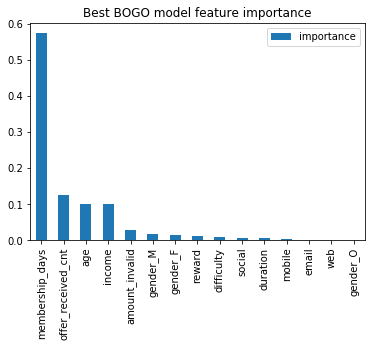

In [94]:
# display the feature importance
# BOGO model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index=features.columns,
                                   columns=['importance']) \
                          .sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

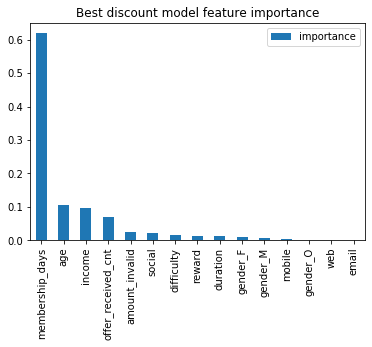

In [95]:
#discount model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']) \
                          .sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

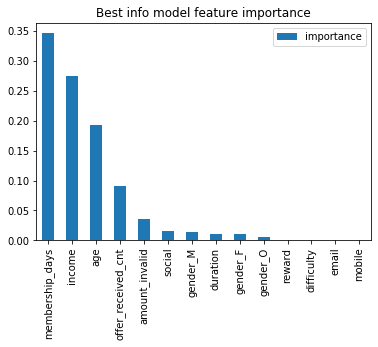

In [96]:
#informational model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(informational_offer,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                   columns=['importance']) \
                          .sort_values('importance',ascending=False)

feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

As shown above, we can see that for all three types of offer, the most important factor that largely affects if the offer will be responded to eventually is the length of membership. That is, the longer the customer as a member of Starbucks, the more likely (s)he will respond to the offer they receive. Then the second and third important factors which affect the possibility of customer's response are age and income which very make sense. Also, the number of offers they received will also affect the response a lot.

## Conclusion & Next steps

### Conclusion

From the result of the project, it's likely to use machine learning model to predict whether the customer will respond to the offer or not, and the model also shows the main factors such as the length of membership, age, income which highly affect the possibility of customer's responding to the offer.

This project is trying to figure out:
- What factors mainly affect the usage of the offer from customer? Should the company send out the offer or not?

For this question, the feature importance given by three models shows that the length of the membership is the most important factor which affect how customer will make reponse to the offer. 

For all three models, the top three variables were pretty same - length of membership, income and age. However, income and age switched orders depending on offer type. And for BOGO offer, the count of offer received is the second important factor which decide if the customer will make the transaction.

- How possible will a customer open and use the offer sent to them? Is there any common characteristics on the customers who take the offer?

In this project, it uses thress separate models to predict if the customer will repond to the offer or not using 'offer_responded' trage variable and finally get the accuracy of 0.83, 0.87, 0.75 for BOGO, discount and informational offer seperatly. Although, the model performance of informational offer is slightly lower but is still acceptable in this phase of research. And for BOGO and discount models, the cost won't be too much to send out the offer even some people doesn't repond to it and it should be fine with this level of model performance.

### Next step

Due to time reasons, I couldn't get a chance to try some other enhancement in the step of model tuning. For example, probably, I can do some more experiment on feature engineering step to see if any other new features can improve the model, also I could also try to reduce some feature to see how it will affect the model performance.

Also, so far the analysis is focused more on customer's who successfully finish the transaction after they received the offer, there should be more insight for the other cases where the customer finishes the transactions regardless of the offer. If we could get any insight into those cases, maybe we can send out more offers to those customers.

In addition, I was thinking if I could do some unsupervised learning on clustering the customers based on information we are given, to see if there are any specific characteristics on a group of customers who will be more likely to respond to the offer.

In [97]:
!jupyter nbconvert  Starbucks_Capstone_notebook.ipynb --to html



[NbConvertApp] Converting notebook Starbucks_Capstone_notebook.ipynb to html
[NbConvertApp] Writing 640903 bytes to Starbucks_Capstone_notebook.html
